In [7]:
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt

# ----------------------------
# 1. Load training and test data
# ----------------------------
# CSVs are in parent directory
train_df = pd.read_csv("../Trainingset_2500.csv")  # Cols 0–4 = inputs, 5–6 = objectives, 7 = wing span
# Drop any rows where the two original objectives are zero
train_df = train_df[(train_df.iloc[:, 5] != 0) & (train_df.iloc[:, 6] != 0)]

test_df  = pd.read_csv("../Testset_10.csv")      # Same format (wing span in col 7)

# Split into X / Y for the three outputs
X_train = train_df.iloc[:, 0:5].values.astype(np.float32)
Y1_train = train_df.iloc[:, 5].values.astype(np.float32)    # Objective 1
Y2_train = train_df.iloc[:, 6].values.astype(np.float32)    # Objective 2
W_train  = train_df.iloc[:, 7].values.astype(np.float32)    # Wing span

X_test  = test_df.iloc[:, 0:5].values.astype(np.float32)
Y1_test = test_df.iloc[:, 5].values.astype(np.float32)
Y2_test = test_df.iloc[:, 6].values.astype(np.float32)
W_test  = test_df.iloc[:, 7].values.astype(np.float32)

# Normalize inputs to [0,1] using training‐set min/max
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)
X_train_norm = (X_train - X_min) / (X_max - X_min)
X_test_norm  = (X_test  - X_min) / (X_max - X_min)

# Convert to torch tensors
train_x    = torch.from_numpy(X_train_norm)
train_y1   = torch.from_numpy(Y1_train.reshape(-1, 1))
train_y2   = torch.from_numpy(Y2_train.reshape(-1, 1))
train_wing = torch.from_numpy(W_train.reshape(-1, 1))

test_x    = torch.from_numpy(X_test_norm)
test_y1   = torch.from_numpy(Y1_test.reshape(-1, 1))
test_y2   = torch.from_numpy(Y2_test.reshape(-1, 1))
test_wing = torch.from_numpy(W_test.reshape(-1, 1))

# ----------------------------
# 2. Define GP model class (same as before)
# ----------------------------
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y.squeeze(), likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )

    def forward(self, x):
        mean_x  = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# ----------------------------
# 3. Instantiate likelihoods and three GP models
# ----------------------------
likelihood1 = gpytorch.likelihoods.GaussianLikelihood()
likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
likelihood3 = gpytorch.likelihoods.GaussianLikelihood()  # for wing‐span

model1 = ExactGPModel(train_x, train_y1, likelihood1)  # Object1
model2 = ExactGPModel(train_x, train_y2, likelihood2)  # Object2
model3 = ExactGPModel(train_x, train_wing, likelihood3)  # Wing span

# ----------------------------
# 4. Train each GP on the training set
# ----------------------------
def train_gp(model, likelihood, x_tr, y_tr, num_iter=300, lr=0.05):
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for _ in range(num_iter):
        optimizer.zero_grad()
        output = model(x_tr)
        loss = -mll(output, y_tr.squeeze())
        loss.backward()
        optimizer.step()
    model.eval()
    likelihood.eval()

# Train all three
train_gp(model1, likelihood1, train_x, train_y1)
train_gp(model2, likelihood2, train_x, train_y2)
train_gp(model3, likelihood3, train_x, train_wing)

# ----------------------------
# 5. Helper to predict any GP’s mean
# ----------------------------
def predict_gp(model, likelihood, x_np):
    """
    x_np: numpy array (n_points, 5) in original‐scale inputs.
    Returns: numpy array of shape (n_points,) = posterior mean.
    """
    x_norm = (x_np - X_min) / (X_max - X_min)
    xt = torch.from_numpy(x_norm.astype(np.float32))
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(xt))
        return preds.mean.cpu().numpy()

# ----------------------------
# 6. Define GA bounds for the five inputs only
# ----------------------------
# (Wing span is not an input, so it won’t appear in individuals.)
BOUND_LOW  = [  8.00,  0.55,   5.00, 0.50,  0.00 ]
BOUND_HIGH = [ 22.00,  1.00,  35.00, 0.85, 40.00 ]

# Penalty value if wing-span > 36
PENALTY = 1e6

# ----------------------------
# 7. GA for Objective 1 with wing‐span constraint
# ----------------------------
import random
from deap import base, creator, tools

creator.create("FitnessMin1", base.Fitness, weights=(-1.0,))  # minimize f1 + penalty
creator.create("Individual1", list, fitness=creator.FitnessMin1)

toolbox1 = base.Toolbox()

# Uniform sampling within each physical bound for the 5 genes
for i in range(5):
    lo, hi = BOUND_LOW[i], BOUND_HIGH[i]
    toolbox1.register(f"attr_float1_{i}", random.uniform, lo, hi)

toolbox1.register(
    "individual",
    tools.initCycle,
    creator.Individual1,
    [toolbox1.attr_float1_0,
     toolbox1.attr_float1_1,
     toolbox1.attr_float1_2,
     toolbox1.attr_float1_3,
     toolbox1.attr_float1_4],
    n=1
)
toolbox1.register("population", tools.initRepeat, list, toolbox1.individual)

def evaluate_obj1_with_constraint(individual):
    """
    individual: list of 5 floats = [x1…x5] in their physical ranges.
    1) Predict wing span with model3.
    2) If wing_pred > 36 → return (PENALTY,).
    3) Else → return (predict_obj1,).
    """
    x_orig = np.array(individual, dtype=np.float32).reshape(1, -1)  # (1,5)
    wing_pred = predict_gp(model3, likelihood3, x_orig)[0]
    if wing_pred > 36.0:
        return (PENALTY,)
    # otherwise, get objective 1 prediction
    f1_pred = predict_gp(model1, likelihood1, x_orig)[0]
    return (float(f1_pred),)

toolbox1.register("evaluate", evaluate_obj1_with_constraint)

# Bounded SBX crossover and polynomial mutation over the 5 genes
ETA_CX   = 20.0
ETA_MUT  = 20.0
MUT_PROB = 1.0 / 5.0

toolbox1.register(
    "mate",
    tools.cxSimulatedBinaryBounded,
    low=BOUND_LOW,
    up=BOUND_HIGH,
    eta=ETA_CX
)
toolbox1.register(
    "mutate",
    tools.mutPolynomialBounded,
    low=BOUND_LOW,
    up=BOUND_HIGH,
    eta=ETA_MUT,
    indpb=MUT_PROB
)
toolbox1.register("select", tools.selTournament, tournsize=3)

def run_ga_obj1(n_pop=200, n_gen=300, cxpb=0.9, mutpb=0.2):
    pop = toolbox1.population(n=n_pop)
    # Evaluate initial pop
    for ind in pop:
        ind.fitness.values = toolbox1.evaluate(ind)
    for gen in range(1, n_gen + 1):
        # Selection
        offspring = toolbox1.select(pop, len(pop))
        offspring = list(map(toolbox1.clone, offspring))
        # Crossover
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= cxpb:
                toolbox1.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values
        # Mutation
        for mutant in offspring:
            if random.random() <= mutpb:
                toolbox1.mutate(mutant)
                del mutant.fitness.values
        # Re‐evaluate infeasible
        invalid = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid:
            ind.fitness.values = toolbox1.evaluate(ind)
        pop = offspring
    return tools.selBest(pop, k=1)[0]

best1 = run_ga_obj1()
x1_best = np.array(best1, dtype=np.float32).tolist()
wing1   = predict_gp(model3, likelihood3, np.array(x1_best).reshape(1, -1))[0]
f1_best = predict_gp(model1, likelihood1, np.array(x1_best).reshape(1, -1))[0]
f2      = predict_gp(model2, likelihood1, np.array(x1_best).reshape(1, -1))[0]

print("\nOptimal for Objective 1 subject to wing_span ≤ 36:")
print(f"  Inputs (orig scale): {x1_best}")
print(f"  Predicted wing span : {wing1:.3f}  (<= 36)")
print(f"  Predicted Obj1      : {f1_best:.6f}")
print(f"  Predicted Obj2      : {f2:.6f}")

# ----------------------------
# 8. GA for Objective 2 with same constraint
# ----------------------------
creator.create("FitnessMin2", base.Fitness, weights=(-1.0,))
creator.create("Individual2", list, fitness=creator.FitnessMin2)

toolbox2 = base.Toolbox()
for i in range(5):
    lo, hi = BOUND_LOW[i], BOUND_HIGH[i]
    toolbox2.register(f"attr_float2_{i}", random.uniform, lo, hi)

toolbox2.register(
    "individual",
    tools.initCycle,
    creator.Individual2,
    [toolbox2.attr_float2_0,
     toolbox2.attr_float2_1,
     toolbox2.attr_float2_2,
     toolbox2.attr_float2_3,
     toolbox2.attr_float2_4],
    n=1
)
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)

def evaluate_obj2_with_constraint(individual):
    x_orig = np.array(individual, dtype=np.float32).reshape(1, -1)
    wing_pred = predict_gp(model3, likelihood3, x_orig)[0]
    if wing_pred > 36.0:
        return (PENALTY,)
    f2_pred = predict_gp(model2, likelihood2, x_orig)[0]
    return (float(f2_pred),)

toolbox2.register("evaluate", evaluate_obj2_with_constraint)

toolbox2.register(
    "mate",
    tools.cxSimulatedBinaryBounded,
    low=BOUND_LOW,
    up=BOUND_HIGH,
    eta=ETA_CX
)
toolbox2.register(
    "mutate",
    tools.mutPolynomialBounded,
    low=BOUND_LOW,
    up=BOUND_HIGH,
    eta=ETA_MUT,
    indpb=MUT_PROB
)
toolbox2.register("select", tools.selTournament, tournsize=3)

def run_ga_obj2(n_pop=200, n_gen=300, cxpb=0.9, mutpb=0.2):
    pop = toolbox2.population(n=n_pop)
    for ind in pop:
        ind.fitness.values = toolbox2.evaluate(ind)
    for gen in range(1, n_gen + 1):
        offspring = toolbox2.select(pop, len(pop))
        offspring = list(map(toolbox2.clone, offspring))
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= cxpb:
                toolbox2.mate(ind1, ind2)
                del ind1.fitness.values
                del ind2.fitness.values
        for mutant in offspring:
            if random.random() <= mutpb:
                toolbox2.mutate(mutant)
                del mutant.fitness.values
        invalid = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid:
            ind.fitness.values = toolbox2.evaluate(ind)
        pop = offspring
    return tools.selBest(pop, k=1)[0]

best2 = run_ga_obj2()
x2_best = np.array(best2, dtype=np.float32).tolist()
wing2   = predict_gp(model3, likelihood3, np.array(x2_best).reshape(1, -1))[0]
f2_best = predict_gp(model2, likelihood2, np.array(x2_best).reshape(1, -1))[0]
f1      = predict_gp(model1, likelihood1, np.array(x2_best).reshape(1, -1))[0]

print("\nOptimal for Objective 2 subject to wing_span ≤ 36:")
print(f"  Inputs (orig scale): {x2_best}")
print(f"  Predicted wing span : {wing2:.3f}  (<= 36)")
print(f"  Predicted Obj1      : {f1:.6f}")
print(f"  Predicted Obj2      : {f2_best:.6f}")


/Users/sv18794/.local/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.003142237663269 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/sv18794/.local/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:338: NumericalWarning: CG terminated in 1000 iterations with average residual norm 1.464247226715088 which is larger than the tolerance of 1 specified by linear_operator.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a linear_operator.settings.max_cg_iterations(value) context.
  warnings.warn(
/Users/sv18794/.local/lib/python3.12/site-packages/linear_operator/utils/linear_cg.py:


Optimal for Objective 1 subject to wing_span ≤ 36:
  Inputs (orig scale): [21.999998092651367, 0.5500001907348633, 5.000006675720215, 0.6658297777175903, 1.890015710159787e-06]
  Predicted wing span : 24.238  (<= 36)
  Predicted Obj1      : 6347.291992
  Predicted Obj2      : 0.016510


/Users/sv18794/.local/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin2' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sv18794/.local/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual2' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Optimal for Objective 2 subject to wing_span ≤ 36:
  Inputs (orig scale): [21.9999942779541, 0.6883655190467834, 19.161409378051758, 0.849876880645752, 1.558973789215088]
  Predicted wing span : 28.729  (<= 36)
  Predicted Obj1      : 7183.464355
  Predicted Obj2      : 0.014867


/Users/sv18794/.local/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sv18794/.local/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


FileNotFoundError: [Errno 2] No such file or directory

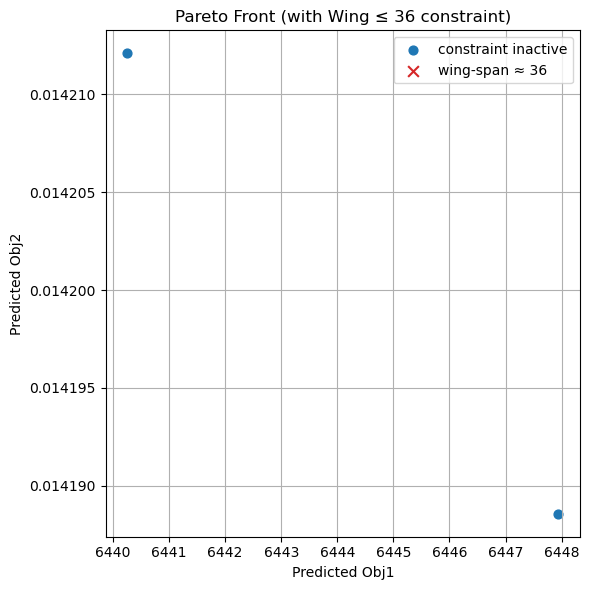

In [8]:
import pandas as pd
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
import random
from deap import base, creator, tools

# ----------------------------
# 0. (Re)load and preprocess data, train 3 GPs as before
# ----------------------------
# CSVs in parent directory
train_df = pd.read_csv("../Trainingset_500.csv")
train_df = train_df[(train_df.iloc[:, 5] != 0) & (train_df.iloc[:, 6] != 0)]

# Inputs (cols 0–4), outputs: obj1=col5, obj2=col6, wing=col7
X = train_df.iloc[:, 0:5].values.astype(np.float32)
Y1 = train_df.iloc[:, 5].values.astype(np.float32)
Y2 = train_df.iloc[:, 6].values.astype(np.float32)
W  = train_df.iloc[:, 7].values.astype(np.float32)

# Normalize X to [0,1] by training mins/maxs
X_min = X.min(axis=0)
X_max = X.max(axis=0)
X_norm = (X - X_min) / (X_max - X_min)

# Torch tensors
train_x    = torch.from_numpy(X_norm)
train_y1   = torch.from_numpy(Y1.reshape(-1, 1))
train_y2   = torch.from_numpy(Y2.reshape(-1, 1))
train_wing = torch.from_numpy(W.reshape(-1, 1))

# GP class
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y.squeeze(), likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1])
        )
    def forward(self, x):
        m = self.mean_module(x)
        c = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(m, c)

# Instantiate and train 3 GPs
lik1 = gpytorch.likelihoods.GaussianLikelihood()
lik2 = gpytorch.likelihoods.GaussianLikelihood()
lik3 = gpytorch.likelihoods.GaussianLikelihood()

model1 = ExactGPModel(train_x, train_y1, lik1)
model2 = ExactGPModel(train_x, train_y2, lik2)
model3 = ExactGPModel(train_x, train_wing, lik3)

def train_gp(model, likelihood, x_tr, y_tr, iters=300, lr=0.05):
    model.train(); likelihood.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    for _ in range(iters):
        opt.zero_grad()
        out = model(x_tr)
        loss = -mll(out, y_tr.squeeze())
        loss.backward()
        opt.step()
    model.eval(); likelihood.eval()

train_gp(model1, lik1, train_x, train_y1)
train_gp(model2, lik2, train_x, train_y2)
train_gp(model3, lik3, train_x, train_wing)

# Prediction helper
def predict_gp(model, likelihood, x_np):
    x_norm = (x_np - X_min) / (X_max - X_min)
    xt = torch.from_numpy(x_norm.astype(np.float32))
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        return likelihood(model(xt)).mean.cpu().numpy()

# ----------------------------
# 1. Run NSGA-II to get Pareto front of (obj1, obj2) with wing-span ≤ 36 constraint
# ----------------------------
# GA will search over 5 inputs in physical ranges:
bounds_low  = [8.00, 0.55, 5.00, 0.50, 0.00]
bounds_high = [22.00, 1.00, 35.00, 0.85, 40.00]

# Penalties if predicted wing > 36
PENALTY = 1e6

creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
for i in range(5):
    lo, hi = bounds_low[i], bounds_high[i]
    toolbox.register(f"attr_float_{i}", random.uniform, lo, hi)

toolbox.register(
    "individual",
    tools.initCycle,
    creator.Individual,
    [toolbox.attr_float_0,
     toolbox.attr_float_1,
     toolbox.attr_float_2,
     toolbox.attr_float_3,
     toolbox.attr_float_4],
    n=1
)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(ind):
    x_orig = np.array(ind, dtype=np.float32).reshape(1, -1)
    # predict wing span
    wing_pred = predict_gp(model3, lik3, x_orig)[0]
    if wing_pred > 36.0:
        return PENALTY, PENALTY
    f1 = predict_gp(model1, lik1, x_orig)[0]
    f2 = predict_gp(model2, lik2, x_orig)[0]
    return float(f1), float(f2)

toolbox.register("evaluate", evaluate)

ETA_CX   = 20.0
ETA_MUT  = 20.0
MUT_PROB = 1.0 / 5.0

toolbox.register(
    "mate",
    tools.cxSimulatedBinaryBounded,
    low=bounds_low,
    up=bounds_high,
    eta=ETA_CX
)
toolbox.register(
    "mutate",
    tools.mutPolynomialBounded,
    low=bounds_low,
    up=bounds_high,
    eta=ETA_MUT,
    indpb=MUT_PROB
)
toolbox.register("select", tools.selNSGA2)

def run_nsga2(n_pop=200, n_gen=300, cxpb=0.9, mutpb=0.2):
    pop = toolbox.population(n_pop)
    for ind in pop:
        ind.fitness.values = toolbox.evaluate(ind)
    for _ in range(n_gen):
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            if random.random() <= cxpb:
                toolbox.mate(ind1, ind2)
                del ind1.fitness.values; del ind2.fitness.values
        for mutant in offspring:
            if random.random() <= mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        invalid = [ind for ind in offspring if not ind.fitness.valid]
        for ind in invalid:
            ind.fitness.values = toolbox.evaluate(ind)
        pop = offspring
    pareto = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    return pareto

pareto_inds = run_nsga2()

# Build pareto_df with inputs, predicted objectives, predicted wing
pareto_sols = []
for ind in pareto_inds:
    x = np.array(ind, dtype=np.float32)
    f1, f2 = evaluate(ind)
    wing = predict_gp(model3, lik3, x.reshape(1, -1))[0]
    pareto_sols.append((*x.tolist(), f1, f2, wing))

cols = ['x1','x2','x3','x4','x5','obj1_pred','obj2_pred','wing_pred']
pareto_df = pd.DataFrame(pareto_sols, columns=cols)

# Mark active wing constraint (within tolerance of 36)
tol = 1e-2
pareto_df['active_constraint'] = pareto_df['wing_pred'] >= (36.0 - tol)

# ----------------------------
# 2. Plot Pareto front in objective space
# ----------------------------
plt.figure(figsize=(6, 6))
inactive = pareto_df[~pareto_df['active_constraint']]
active   = pareto_df[ pareto_df['active_constraint']]

plt.scatter(inactive['obj1_pred'], inactive['obj2_pred'],
            c='tab:blue', label='constraint inactive', s=40)
plt.scatter(active['obj1_pred'], active['obj2_pred'],
            c='tab:red', label='wing-span ≈ 36', s=60, marker='x')

plt.xlabel("Predicted Obj1")
plt.ylabel("Predicted Obj2")
plt.title("Pareto Front (with Wing ≤ 36 constraint)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pareto_front_objectives.png", dpi=150)

# ----------------------------
# 3. Histograms of each input among Pareto solutions
# ----------------------------
input_cols = ['x1','x2','x3','x4','x5']
for col in input_cols:
    plt.figure(figsize=(6, 4))
    plt.hist(pareto_df[col], bins=15, color='lightgray', edgecolor='black', alpha=0.7, label='All Pareto')
    plt.hist(active[col], bins=15, color='tab:red', alpha=0.8, label='Active (wing≈36)')
    plt.xlabel(f"{col} (orig scale)")
    plt.ylabel("Count")
    plt.title(f"Pareto Distribution of {col}")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig(f"pareto_hist_{col}.png", dpi=150)

# ----------------------------
# 4. Pairwise scatterplots (example: x1 vs x2, x1 vs x3, x2 vs x3)
# ----------------------------
pairs = [('x1','x2'), ('x1','x3'), ('x2','x3')]
for a, b in pairs:
    plt.figure(figsize=(5, 5))
    plt.scatter(inactive[a], inactive[b], c='tab:blue', label='inactive', s=30, alpha=0.7)
    plt.scatter(active[a], active[b], c='tab:red', label='active', s=50, marker='x')
    plt.xlabel(f"{a}")
    plt.ylabel(f"{b}")
    plt.title(f"Pareto: {a} vs {b}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"pareto_scatter_{a}_{b}.png", dpi=150)

# ----------------------------
# 5. Wing span vs. each input
# ----------------------------
for col in input_cols:
    plt.figure(figsize=(6, 4))
    plt.scatter(pareto_df[col], pareto_df['wing_pred'],
                c=pareto_df['active_constraint'].map({False:'tab:blue', True:'tab:red'}),
                s=40, alpha=0.7)
    plt.axhline(36.0, color='gray', linestyle='--')
    plt.xlabel(f"{col}")
    plt.ylabel("Predicted Wing Span")
    plt.title(f"Wing Span vs {col}")
    plt.legend(handles=[
        plt.Line2D([], [], marker='o', color='w', markerfacecolor='tab:blue', markersize=8, label='wing<36'),
        plt.Line2D([], [], marker='x', color='tab:red', markersize=8, label='wing≈36'),
        plt.Line2D([], [], linestyle='--', color='gray', label='wing=36')
    ])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"wingspan_vs_{col}.png", dpi=150)

# ----------------------------
# 6. 2D heatmap slice for (x1,x2) showing wing-span feasibility
# ----------------------------
x3_fix = pareto_df['x3'].mean()
x4_fix = pareto_df['x4'].mean()
x5_fix = pareto_df['x5'].mean()

n_grid = 100
x1_lin = np.linspace(bounds_low[0], bounds_high[0], n_grid)
x2_lin = np.linspace(bounds_low[1], bounds_high[1], n_grid)
X1, X2 = np.meshgrid(x1_lin, x2_lin)

grid = np.column_stack([
    X1.ravel(), X2.ravel(),
    np.full(X1.size, x3_fix),
    np.full(X1.size, x4_fix),
    np.full(X1.size, x5_fix)
])
wing_grid = predict_gp(model3, lik3, grid).reshape(n_grid, n_grid)

plt.figure(figsize=(6, 5))
cs = plt.contourf(X1, X2, wing_grid, levels=50, cmap='viridis')
cbar = plt.colorbar(cs)
cbar.set_label("Predicted Wing Span")
plt.contour(X1, X2, wing_grid, levels=[36.0], colors='red', linewidths=2, linestyles='--')
plt.scatter(pareto_df['x1'], pareto_df['x2'],
            c='white', edgecolor='black', label='Pareto', s=30)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Wing-Span Heatmap (x3,x4,x5 fixed at Pareto means)")
plt.legend()
plt.tight_layout()
plt.savefig("wingspan_heatmap_x1_x2.png", dpi=150)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Prerequisites: 
#  - model1, model2, model3, lik1, lik2, lik3 are already trained GPs
#  - X_min, X_max arrays for input normalization
#  - predict_gp(model, likelihood, x_np) function defined as before
#  - pareto_df DataFrame exists with columns ['x1','x2','x3','x4','x5','obj1_pred','obj2_pred','wing_pred']
# ----------------------------

# 1. Choose two input axes for the 2D slice (e.g. x1 vs. x2)
#    and fix the other three at their Pareto‐mean values.
x3_fix = pareto_df['x3'].mean()
x4_fix = pareto_df['x4'].mean()
x5_fix = pareto_df['x5'].mean()

# 2. Define grid ranges (same as GA bounds for those inputs):
x1_min, x1_max = 8.00, 22.00
x2_min, x2_max = 0.55,  1.00
n_grid = 200

x1_lin = np.linspace(x1_min, x1_max, n_grid)
x2_lin = np.linspace(x2_min, x2_max, n_grid)
X1, X2 = np.meshgrid(x1_lin, x2_lin)

# 3. Build NxN×5 array of input points for prediction
#    Each row = [x1, x2, x3_fix, x4_fix, x5_fix]
grid_points = np.column_stack([
    X1.ravel(), 
    X2.ravel(),
    np.full(X1.size, x3_fix),
    np.full(X1.size, x4_fix),
    np.full(X1.size, x5_fix),
])

# 4. Predict wing‐span, obj1, and obj2 on the grid
wing_grid = predict_gp(model3, lik3, grid_points).reshape(n_grid, n_grid)
obj1_grid = predict_gp(model1, lik1, grid_points).reshape(n_grid, n_grid)
obj2_grid = predict_gp(model2, lik2, grid_points).reshape(n_grid, n_grid)

# 5. Mask any points where wing‐span > 36 (infeasible region)
feasible_mask = (wing_grid <= 36.0)

# 6. Plot heatmap for Objective 1
plt.figure(figsize=(6, 5))
# Use a clipped colormap so that infeasible areas are gray
obj1_plot = np.ma.array(obj1_grid, mask=~feasible_mask)
cmap1 = plt.cm.viridis
cmap1.set_bad(color='lightgray')

cf1 = plt.contourf(X1, X2, obj1_plot, levels=50, cmap=cmap1)
plt.colorbar(cf1, label="Predicted Obj1")
# Overlay constraint boundary (wing = 36)
cs1 = plt.contour(X1, X2, wing_grid, levels=[36.0], colors='red', linewidths=2, linestyles='--')
# Overlay Pareto points projected onto x1,x2
plt.scatter(pareto_df['x1'], pareto_df['x2'],
            c='white', edgecolor='black', s=30, label='Pareto Points')
plt.xlabel("x1 (orig scale)")
plt.ylabel("x2 (orig scale)")
plt.title("Obj1 Heatmap (slice at x3,x4,x5 = means)\nGray = infeasible (wing>36)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("heatmap_obj1.png", dpi=150)
plt.close()

# 7. Plot heatmap for Objective 2
plt.figure(figsize=(6, 5))
obj2_plot = np.ma.array(obj2_grid, mask=~feasible_mask)
cmap2 = plt.cm.plasma
cmap2.set_bad(color='lightgray')

cf2 = plt.contourf(X1, X2, obj2_plot, levels=50, cmap=cmap2)
plt.colorbar(cf2, label="Predicted Obj2")
plt.contour(X1, X2, wing_grid, levels=[36.0], colors='red', linewidths=2, linestyles='--')
plt.scatter(pareto_df['x1'], pareto_df['x2'],
            c='white', edgecolor='black', s=30, label='Pareto Points')
plt.xlabel("x1 (orig scale)")
plt.ylabel("x2 (orig scale)")
plt.title("Obj2 Heatmap (slice at x3,x4,x5 = means)\nGray = infeasible (wing>36)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("heatmap_obj2.png", dpi=150)
plt.close()

# 8. Combined 2D plot showing both objectives’ Pareto front
plt.figure(figsize=(6, 6))
plt.scatter(pareto_df['obj1_pred'], pareto_df['obj2_pred'],
            c='tab:blue', label='Pareto Front', s=40)
# Highlight active constraint points
active = pareto_df[pareto_df['wing_pred'] >= 36.0 - 1e-2]
plt.scatter(active['obj1_pred'], active['obj2_pred'],
            c='tab:red', marker='x', s=60, label='wing ≈ 36')
plt.xlabel("Predicted Obj1")
plt.ylabel("Predicted Obj2")
plt.title("Pareto Front in Objective Space\n(Red = active wing-span constraint)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pareto_obj_space.png", dpi=150)
plt.close()

print("Saved: heatmap_obj1.png, heatmap_obj2.png, pareto_obj_space.png")


Saved: heatmap_obj1.png, heatmap_obj2.png, pareto_obj_space.png
